In [6]:
import os
os.chdir('/Users/philippratz/Documents/Uni/PhD/UQAM/courses/RL/mcgill_precup/project/')

import numpy as np
import pandas as pd
import random
from collections import namedtuple, deque


# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

In [7]:
%load_ext pycodestyle_magic
%load_ext autoreload

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
%autoreload 2
from main.discrete_agents import StateMapper, TabularQ, SimpleEconEnvironment

In [9]:
env = SimpleEconEnvironment()

In [ ]:
env()

In [10]:
linspace_ = np.linspace(1.47293 - 0.3*(1.92-1.47293),
                       1.92  + 0.3*(1.92-1.47293), 
                       50)
action_dict = dict(zip(range(50), linspace_))

env_test = SimpleEconEnvironment()

respnse_2 = []
profit_2 = []
profit_1 = []
grid_x = []
grid_y = []
profit = []

for p1 in list(action_dict.values()):
    for p2 in list(action_dict.values()):

        d1, d2 = env_test(p1, p2)

        prof1 = d1*(p1-1)
        prof2 = d2*(p2-1)

        aggregated_prof = prof1 + prof2

        grid_x.append(p1)
        grid_y.append(p2)
        profit.append(aggregated_prof)
        
        profit_1.append(prof1)
        profit_2.append(prof2)
        respnse_2.append(p2)

In [38]:
pd.DataFrame({'x':grid_x, 'y':grid_y, 'c': profit}).to_csv('~/Downloads/check_grid1_total_col.csv', index=False)

In [11]:
# Multiagents

import numpy as np

class SimpleEconEnvironmentFive:
    def __init__(self, mu=0.25, a_vec=np.array([0,2,2,2,2,2])):
        self.mu = mu
        self.a_vec = a_vec
    
    def aggregate_demand(self, p1, p2, p3, p4, p5):
        p_vec = np.array([0, p1, p2, p3, p4, p5])
        all_terms = np.exp((self.a_vec - p_vec)/self.mu)
        return (all_terms / np.sum(all_terms))[1:]
    
    def __call__(self, p1, p2, p3, p4, p5):
        return self.aggregate_demand(p1, p2, p3, p4, p5)

In [47]:
env_test = SimpleEconEnvironmentFive()
env_test(1.31153,1.31153,1.31153,1.31153,1.31153)
.31153*0.19748482

0.0615224459746

In [41]:
linspace_ = np.linspace(1,
                        2,
                        15)
action_dict = dict(zip(range(15), linspace_))

env_test = SimpleEconEnvironmentFive()

grid_1 = []
grid_2 = []
grid_3 = []
grid_4 = []
grid_5 = []
profit = []

for p1 in list(action_dict.values()):
    for p2 in list(action_dict.values()):
        for p3 in list(action_dict.values()):
            for p4 in list(action_dict.values()):
                for p5 in list(action_dict.values()):
                                

                    d1, d2, d3, d4, d5 = env_test(p1, p2, p3, p4, p5)

                    prof1 = d1*(p1-1)
                    prof2 = d2*(p2-1)
                    prof3 = d3*(p3-1)
                    prof4 = d4*(p4-1)
                    prof5 = d5*(p5-1)

                    aggregated_prof = prof1 + prof2 + prof3 + prof4 + prof5

                    grid_1.append(p1)
                    grid_2.append(p2)
                    grid_3.append(p3)
                    grid_4.append(p4)
                    grid_5.append(p5)

                    profit.append(aggregated_prof)

In [42]:
pd.DataFrame({'x':grid_1,
              'y':grid_2,
              'z': grid_3,
              'q':grid_4,
              'u':grid_5,
              'c': profit}).to_csv('~/Downloads/check_grid5_total_col.csv', index=False)

0.4534537380769726
2475


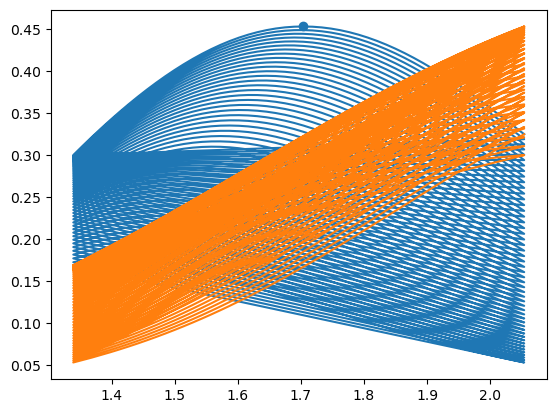

In [12]:
plt.plot(respnse_2, profit_2)
plt.plot(respnse_2, profit_1)
plt.scatter(respnse_2[np.argmax(profit_2)], np.max(profit_2))
print(np.max(profit_2))
print(np.argmax(profit_2))

In [84]:
from collections import namedtuple, deque

class BaseMLP(nn.Module):
    def __init__(self, arch,
                 input_size=2,
                 output_size = 1,
                 dropout=0.1):
        super().__init__()
        self.output_size = output_size
        self.input_size = input_size
        self.layers = nn.ModuleList()
        self.dropout = nn.Dropout(dropout)
        self._set_arch(arch, input_size)

    def _set_arch(self, arch, input_size):
        current_size = input_size
        for lay_size in arch:
            self.layers.append(nn.Linear(current_size, lay_size))
            current_size = lay_size
            
        self.final_layer = nn.Linear(current_size, self.output_size)

    def forward(self, x):
        for lay_ in self.layers:
            x = F.relu(lay_(x))
            x = self.dropout(x)
            
        x = self.final_layer(x)
        
        return x
    
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    

def initalize_replay_buffer(enviornment_, state_memory_length=1, players=2):
    replay_buffer = ReplayMemory(1000)
    
    state_vec = np.random.uniform(low=1, high=2.5, size=(state_memory_length*players, ))

    for simple_mem in range(128):
        # will left append new states so need the last two prices
        all_demands = enviornment_(state_vec[-1], state_vec[-2])

        demand_1 = all_demands[0]

        state = torch.from_numpy(np.float32(state_vec)).reshape(1,-1)
        action = torch.tensor([random.choices(range(15), k=1)]).reshape(1,-1)
        # get last price (aka players price from state)
        reward = torch.tensor((state_vec[-1] - 1)*demand_1).reshape(1,-1)

        # sample new prices
        new_prices = np.random.uniform(low=1, high=2.5, size=(players,))

        # set up next state
        next_state_vec = np.concatenate([state_vec[players:], new_prices])
        next_state = torch.from_numpy(np.float32(next_state_vec)).reshape(1,-1)

        replay_buffer.push(state, action, next_state, reward)

        state_vec = next_state_vec

    return replay_buffer

def train_model(replay_buffer, model, target_model, optimizer, batch_size=128):

    trans_sample = replay_buffer.sample(batch_size)
    batch = Transition(*zip(*trans_sample))

    sample_state = torch.cat(batch.state)
    sample_reward = torch.cat(batch.reward)
    sample_action = torch.cat(batch.action)
    sample_next_state = torch.cat(batch.next_state)

    # cast to avoid issues with torch
    sample_state = sample_state.type(torch.FloatTensor)
    sample_next_state = sample_next_state.type(torch.FloatTensor)

    q_values_hat = model(sample_state).gather(1,sample_action)

    # No grad here as we do not optimize target net
    target_model.eval()
    with torch.no_grad():
        next_q_val, _ = target_model(sample_next_state).max(1)
    target_model.train()
    
    target_value = sample_reward.squeeze() + gamma* next_q_val
    
    criterion = nn.SmoothL1Loss()
    loss = criterion(q_values_hat.squeeze(), target_value)

    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(model.parameters(), 100)
    optimizer.step()


def soft_update_nets(model, target_model, tau):
    target_states = target_model.state_dict()
    model_states = model.state_dict()

    for key in model_states:
        target_states[key] = tau*model_states[key] + (1-tau)*target_states[key]
    target_model.load_state_dict(target_states)


def select_action_training(model, state, epsilon):
     if np.random.uniform() > epsilon:
        model.eval()
        with torch.no_grad():
            _, action_idx = model(state).reshape(1,-1).max(1)

        model.train()
        return action_idx
     else:
        return torch.tensor([random.choices(range(n_actions), k=1)])
    

In [ ]:
## Simulation 
# Parameters
players=2
state_memory=6
n_actions = 15
gamma = 0.95

batch_size=256
total_iterations = 50000
shift_delay = 1

total_experiments = 10

# Initialize enviornment, state and action dict
envir_two_agents = SimpleEconEnvironment(mu=0.25)
linspace_ = np.linspace(1.47293 - 0.1*(1.92-1.47293),
                       1.92  + 0.1*(1.92-1.47293), 
                       15)
action_dict = dict(zip(range(15), linspace_))

# To catch results
all_exper_rewards_1 = []
all_exper_rewards_2 = []

for experiment_ in range(total_experiments):
    print(experiment_)

    epsilon_init=0.1
    epsilon_decay=0.0001

    tau = 0.025
    tau_decay = 0.000001

    learning_rate=0.025

    replay_buffer_1 = ReplayMemory(1000)#initalize_replay_buffer(envir_two_agents, state_memory_length=state_memory)
    replay_buffer_2 = ReplayMemory(1000)#initalize_replay_buffer(envir_two_agents, state_memory_length=state_memory)

    # Initialize nets
    # Agent 1
    policy_net_a1 = BaseMLP([5,5,5], input_size=state_memory*players, output_size=n_actions)
    target_net_a1 = BaseMLP([5,5,5], input_size=state_memory*players, output_size=n_actions)
    target_net_a1.load_state_dict(policy_net_a1.state_dict())
    optimizer_a1 = optim.AdamW(policy_net_a1.parameters(), lr=learning_rate, amsgrad=True)

    # Agent 2
    policy_net_a2 = BaseMLP([5,5,5], input_size=state_memory*players, output_size=n_actions)
    target_net_a2 = BaseMLP([5,5,5], input_size=state_memory*players, output_size=n_actions)
    target_net_a2.load_state_dict(policy_net_a2.state_dict())
    optimizer_a2 = optim.AdamW(policy_net_a2.parameters(), lr=learning_rate, amsgrad=True)

    # Initialize a state
    state = torch.tensor(np.random.uniform(low=1.47,
                                           high=2, size=(players*state_memory,)),
                         dtype=torch.float32).reshape(1,players*state_memory)

    rewards_a1 = []
    rewards_a2 = []

    for train_iter_ in range(total_iterations):

        if train_iter_ > batch_size:

            action_a1 = select_action_training(policy_net_a1, state, epsilon_init)
            action_value_a1 = int(action_a1.detach().numpy()[0])
            price_a1 = action_dict[action_value_a1]

            action_a2 = select_action_training(policy_net_a2, state, epsilon_init)
            action_value_a2 = int(action_a2.detach().numpy()[0])
            price_a2 = action_dict[action_value_a2]

            price_tensor = torch.tensor([price_a1, price_a2], 
                                        dtype=torch.float32).reshape(1,-1)
            price_tensor1 = torch.tensor([price_a2, price_a1], 
                                        dtype=torch.float32).reshape(1,-1)
    
            demand_1, demand_2 = envir_two_agents(price_a1, price_a2)

            reward_a1 = torch.tensor((price_a1 - 1)*demand_1).reshape(1,-1)
            reward_a2 = torch.tensor((price_a2 - 1)*demand_2).reshape(1,-1)

            rewards_a1.append((price_a1 - 1)*demand_1)
            rewards_a2.append((price_a2 - 1)*demand_2)

            replay_buffer_1.push(state, action_a1.reshape(1,1), next_state, reward_a1)
            replay_buffer_2.push(state, action_a2.reshape(1,1), next_state, reward_a2)

            # Train policy model 
            train_model(replay_buffer_1, policy_net_a1, target_net_a1, optimizer_a1, batch_size=128)
            train_model(replay_buffer_2, policy_net_a2, target_net_a2, optimizer_a2, batch_size=128)

#            epsilon_init = epsilon_init*(1-epsilon_decay)
            epsilon_init = np.exp(-(train_iter_-batch_size)*5e-4)


            if train_iter_ % shift_delay == 0:
                soft_update_nets(policy_net_a1, target_net_a2, tau)
                soft_update_nets(policy_net_a2, target_net_a2, tau)

                tau = tau*(1-tau_decay)
        
        else:
            action_a1 = select_action_training(policy_net_a1, state, epsilon_init)
            action_value_a1 = int(action_a1.detach().numpy()[0])
            price_a1 = action_dict[action_value_a1]

            action_a2 = select_action_training(policy_net_a2, state, epsilon_init)
            action_value_a2 = int(action_a2.detach().numpy()[0])
            price_a2 = action_dict[action_value_a2]

            price_tensor = torch.tensor([price_a1, price_a2], 
                                        dtype=torch.float32).reshape(1,-1)
            
            demand_1, demand_2 = envir_two_agents(price_a1, price_a2)

            reward_a1 = torch.tensor((price_a1 - 1)*demand_1).reshape(1,-1)
            reward_a2 = torch.tensor((price_a2 - 1)*demand_2).reshape(1,-1)

            rewards_a1.append((price_a1 - 1)*demand_1)
            rewards_a2.append((price_a2 - 1)*demand_2)

            next_state = torch.cat([state[:,players:], price_tensor], 1)

            replay_buffer_1.push(state, action_a1.reshape(1,1), next_state, reward_a1)
            replay_buffer_2.push(state, action_a2.reshape(1,1), next_state, reward_a2)


    all_exper_rewards_1.append(rewards_a1)
    all_exper_rewards_2.append(rewards_a2)

In [65]:
linspace_ = np.linspace(1.47293 - 0.3*(1.92-1.47293),
                       1.92  + 0.3*(1.92-1.47293), 
                       25)
action_dict = dict(zip(range(25), linspace_))

In [66]:
env_test = SimpleEconEnvironment()

In [26]:
linspace_ = np.linspace(1.47293 - 0.3*(1.92-1.47293),
                       1.92  + 0.3*(1.92-1.47293), 
                       25)
action_dict = dict(zip(range(25), linspace_))

env_test = SimpleEconEnvironment()

respnse_2 = []
profit_2 = []
profit_1 = []

for p1 in [list(action_dict.values())[19]]:
    for p2 in list(action_dict.values()):
        # p1 = list(action_dict.values())[-1]
        # p2 = list(action_dict.values())[-1]

        d1, d2 = env_test(p1, p2)

        prof1 = d1*(p1-1)
        prof2 = d2*(p2-1)
        
        profit_1.append(prof1)
        profit_2.append(prof2)
        respnse_2.append(p2)

In [20]:
data_viz_2 = pd.DataFrame({
    'price_prop': respnse_2, 
    'profit_2': profit_2, 
    'profit_1': profit_1
}).to_csv('data/results/price_dynamics_monopoly.csv', index=False)

In [25]:
action_dict

{0: 1.3388090000000001,
 1: 1.3686136666666668,
 2: 1.3984183333333335,
 3: 1.428223,
 4: 1.4580276666666667,
 5: 1.4878323333333334,
 6: 1.5176370000000001,
 7: 1.5474416666666668,
 8: 1.5772463333333333,
 9: 1.607051,
 10: 1.6368556666666667,
 11: 1.6666603333333334,
 12: 1.696465,
 13: 1.7262696666666666,
 14: 1.7560743333333333,
 15: 1.785879,
 16: 1.8156836666666667,
 17: 1.8454883333333334,
 18: 1.875293,
 19: 1.9050976666666666,
 20: 1.9349023333333333,
 21: 1.9647069999999998,
 22: 1.9945116666666665,
 23: 2.024316333333333,
 24: 2.054121}

In [27]:
respnse_2[np.argmax(profit_2)], np.max(profit_2)

(1.6666603333333334, 0.40430998266850926)

0.40430998266850926
11


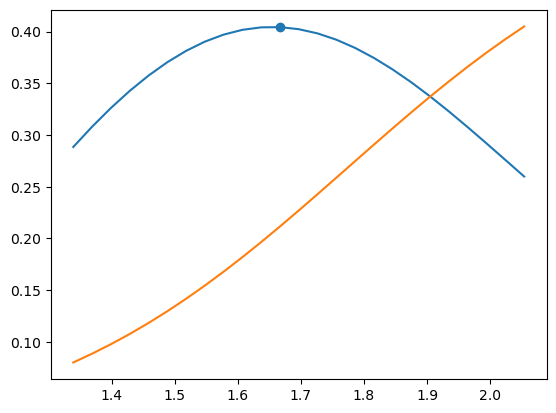

In [21]:
plt.plot(respnse_2, profit_2)
plt.plot(respnse_2, profit_1)
plt.scatter(respnse_2[np.argmax(profit_2)], np.max(profit_2))
print(np.max(profit_2))
print(np.argmax(profit_2))

In [28]:
linspace_ = np.linspace(1.47293 - 0.3*(1.92-1.47293),
                       1.92  + 0.3*(1.92-1.47293), 
                       25)
action_dict = dict(zip(range(25), linspace_))

env_test = SimpleEconEnvironment()

respnse_2 = []
profit_2 = []
profit_1 = []

for p1 in [list(action_dict.values())[5]]:
    for p2 in list(action_dict.values()):
        # p1 = list(action_dict.values())[-1]
        # p2 = list(action_dict.values())[-1]

        d1, d2 = env_test(p1, p2)

        prof1 = d1*(p1-1)
        prof2 = d2*(p2-1)
        
        profit_1.append(prof1)
        profit_2.append(prof2)
        respnse_2.append(p2)

In [29]:
respnse_2[np.argmax(profit_2)], np.max(profit_2)

(1.4878323333333334, 0.22914694176000214)

0.22914694176000214
5


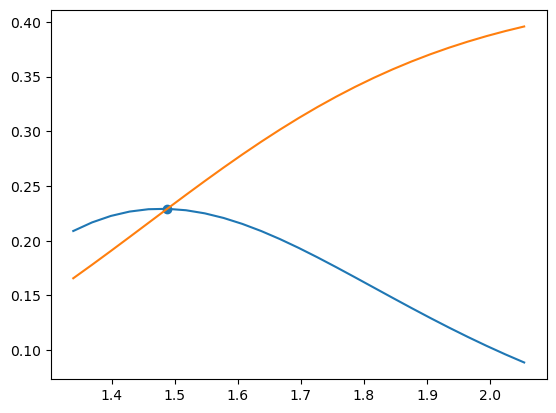

In [23]:
plt.plot(respnse_2, profit_2)
plt.plot(respnse_2, profit_1)
plt.scatter(respnse_2[np.argmax(profit_2)], np.max(profit_2))
print(np.max(profit_2))
print(np.argmax(profit_2))

In [24]:
data_viz_2 = pd.DataFrame({
    'price_prop': respnse_2, 
    'profit_2': profit_2, 
    'profit_1': profit_1
}).to_csv('data/results/price_dynamics_duopoly.csv', index=False)

In [1]:
plt.plot(respnse_2, profit_2)
plt.plot(respnse_2, profit_1)
plt.scatter(respnse_2[np.argmax(profit_2)], np.max(profit_2))
print(np.max(profit_2))
print(np.argmax(profit_2))

NameError: name 'plt' is not defined

# Simple Function approx

In [90]:
class BaseMLP(nn.Module):
    def __init__(self, arch,
                 input_size=2,
                 output_size = 1,
                 dropout=0.1):
        super().__init__()
        self.output_size = output_size
        self.input_size = input_size
        self.layers = nn.ModuleList()
        self.dropout = nn.Dropout(dropout)
        self._set_arch(arch, input_size)

    def _set_arch(self, arch, input_size):
        current_size = input_size
        for lay_size in arch:
            self.layers.append(nn.Linear(current_size, lay_size))
            current_size = lay_size
            
        self.final_layer = nn.Linear(current_size, self.output_size)

    def forward(self, x):
        for lay_ in self.layers:
            x = F.relu(lay_(x))
            x = self.dropout(x)
            
        x = self.final_layer(x)
        
        return x
    
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
class DeepQAgent:
    def __init__(self, mlp, low_price, high_price):
        self._mlp = mlp
        self.low_price = low_price
        self.high_price = high_price
    
    def predict_best_response(self, state_vector):
        if type(state_vector) != torch.Tensor:
            state_vector = torch.from_numpy(state_vector)
            
        with torch.no_grad():
            response_price = self._mlp(state_vector).detach().numpy()[0]
        
        return response_price
    
    def select_response(self, state_vector, epsilon):
        if np.random.uniform() <= epsilon:
            response = np.random.uniform(low=self.low_price, 
                                         high=self.high_price)
        else:
            response = self.predict_best_response(state_vector)
            
        return response

In [ ]:
total_trials = 10
total_training_1 = []
total_training_2 = []

lower=1.47
upper=1.92498
num_bins=15
xi=0.1
state_mapper = StateMapper(lower=lower, upper=upper)

linspace_ = np.round(np.linspace(lower - xi*(upper-lower),
                                 upper + xi*(upper-lower),
                                 num_bins), 15)
action_dict = dict(zip(range(15), linspace_))

for trial_ in range(total_trials):
    
    environment = SimpleEconEnvironment(mu=0.25)

    state_mapper = StateMapper(lower=1.47)
    agent_1 = QLearningAgentBase(0.05, 0.9, 0.95, 15, 225)
    agent_2 = QLearningAgentBase(0.05, 0.9, 0.95, 15, 225)

    # epsilon=0.1
    epsilon_decay = 0.25e-4
    # lr_decay = 0
    total_runs = 600000
    profit_training_run_1 = []
    profit_training_run_2 = []

    p1_hist, p2_hist = np.random.choice(state_mapper.bins,2)
    state = state_mapper(p1_hist, p2_hist)
    # state_1 = state_mapper(p1_hist, p2_hist)
    # state_2 = state_mapper(p2_hist, p1_hist)

    for run in range(total_runs):

        action_1, _ = agent_1.get_action(state)
        p1 = action_dict[action_1]

        action_2, _ = agent_2.get_action(state)
        p2 = action_dict[action_2]

        share_1, share_2 = environment(p1, p2)

        profit_1 = share_1 * (p1-1)
        profit_2 = share_2 * (p2-1)
        
        profit_training_run_1.append(profit_1)
        profit_training_run_2.append(profit_2)

        new_state = state_mapper(p1, p2)
        # new_state_1 = state_mapper(p1, p2)
        # new_state_2 = state_mapper(p2, p1)

        agent_1.update(state_1, action_1, profit_1, new_state)
        agent_2.update(state_2, action_2, profit_2, new_state)

        state = new_state
        # state_2 = new_state_2

        agent_1.epsilon = np.exp(-run*0.5e-5)
        agent_2.epsilon = np.exp(-run*0.5e-5)
        
    total_training_1.append(profit_training_run_1)
    total_training_2.append(profit_training_run_2)
    print(trial_)
